<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Предварительный-анализ-данных" data-toc-modified-id="Предварительный-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предварительный анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вase" data-toc-modified-id="Вase-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Вase</a></span></li></ul></li><li><span><a href="#Тренировочная-выборка" data-toc-modified-id="Тренировочная-выборка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Тренировочная выборка</a></span></li><li><span><a href="#Validation" data-toc-modified-id="Validation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Validation</a></span></li><li><span><a href="#Answer" data-toc-modified-id="Answer-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Answer</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Запишем-названия-признаков-в-нижнем-регистре" data-toc-modified-id="Запишем-названия-признаков-в-нижнем-регистре-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Запишем названия признаков в нижнем регистре</a></span></li><li><span><a href="#Поменяем-тип-данных" data-toc-modified-id="Поменяем-тип-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Поменяем тип данных</a></span></li><li><span><a href="#Уберем-категориальные-данные" data-toc-modified-id="Уберем-категориальные-данные-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Уберем категориальные данные</a></span></li><li><span><a href="#Перезапишем-id" data-toc-modified-id="Перезапишем-id-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Перезапишем id</a></span></li><li><span><a href="#Масштабируем-признаки" data-toc-modified-id="Масштабируем-признаки-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Масштабируем признаки</a></span></li><li><span><a href="#Подберем-класторы" data-toc-modified-id="Подберем-класторы-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Подберем класторы</a></span></li></ul></li><li><span><a href="#Faiss" data-toc-modified-id="Faiss-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Faiss</a></span><ul class="toc-item"><li><span><a href="#Train" data-toc-modified-id="Train-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Valid" data-toc-modified-id="Valid-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Valid</a></span></li></ul></li></ul></div>

# Мэтчинг товаров

__Задача:__ 

1) Необходимо разработать алгоритм для маркетплейса, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base.cvs. 

__Метрика.__

1) Необходимо максимизировать метрику `accuracy@5`, которая для каждого объекта вычисляется по формуле:
$$
accuracy@5 = 100 * \frac{\text{кол-во верно определённых похожих объектов из 5 возможных}} {5}
$$


__Данные:__

1) base.csv - анонимизированный набор всех товаров. Каждый товар имеет уникальный id. Вектор признаков имеет размерностью 72 и количество значения 2918139.

2) train.csv - обучающий набор товаров. Каждый товар имеет уникальный id. Вектор признаков имеет размерность 73 и количество значений 100000.

3) validation.csv - набор товаров, для которых надо найти наиболее близкие товары из base.csv. Вектор признаков имеет размерность 72 количество значений 100000. 

4) validation_answer.csv - набор товаров, с разметкой похожих для товаров из validatation.csv. Каждый товар имеет уникальный id. Количество значений 100000.

__План работы__:
- Загрузка библиотек.
- Установка параметров проекта.
- Ознакомление с данными.
- Анализ и предобработка данных.
- Вычисление оптимального кол-ва кластеров.
- Обучение модели с разными индексами.
- Тесты модели.

In [1]:
# импортирую нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import faiss
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import davies_bouldin_score
from tqdm import tqdm

from warnings import simplefilter
simplefilter(action='ignore', category=Warning)

In [2]:
# константы
RANDOM_STATE = 42
N_CLUSTERS = 10
K_NEIGHBORS = 5
NPROBE = 10 

In [3]:
# Устанавливаю отображение столбцов при выводе датафрейма
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Подготовка данных

### Предварительный анализ данных

In [4]:
%%time
# загружаю данные base
try:
    data_base = pd.read_csv('/Users/tanya/Documents/DS/Projects/data_matching/data/base.csv')
except:
    pass        

CPU times: user 1min 4s, sys: 12.3 s, total: 1min 16s
Wall time: 1min 25s


In [5]:
%%time
# загружаю данные train
try:
    data_train = pd.read_csv('/Users/tanya/Documents/DS/Projects/data_matching/data/train.csv')
except:
    pass

CPU times: user 2.72 s, sys: 324 ms, total: 3.04 s
Wall time: 3.32 s


In [6]:
%%time
# загружаю данные answer
try:
    data_valid_answer = pd.read_csv('/Users/tanya/Documents/DS/Projects/data_matching/data/validation_answer.csv')
except:
    pass        

CPU times: user 140 ms, sys: 22.6 ms, total: 163 ms
Wall time: 226 ms


In [7]:
%%time
# загружаю данные valid
try:
    data_valid = pd.read_csv('/Users/tanya/Documents/DS/Projects/data_matching/data/validation.csv')
except:
    pass

CPU times: user 2.54 s, sys: 251 ms, total: 2.79 s
Wall time: 2.96 s


In [8]:
# функция для изучения данных
def info(data):
    display(data.info())
    display(data.sample(10))
    display(data.describe().T)
    print(data.isna().sum())
    print('Количество дубликатов: ', data.duplicated().sum())
    print('Количество признаков: ', data.shape[1], 'Количество значений: ', data.shape[0])

#### Вase

In [9]:
# изучим данные base
info(data_base)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
61779,62644-base,-58.454483,4.632728,-44.345913,-142.155000,97.925896,-98.604030,-365.413439,51.658130,115.701920,61.800117,-102.148940,-83.162670,-107.446690,-53.037400,134.70642,0.500214,27.539550,-29.813140,-182.257680,-80.464905,-49.494747,1507.231274,-85.242360,37.969604,-3.433550,813.770071,-130.807250,13.597345,-38.97014,157.30345,-13.030434,-124.341040,70.944400,-156.249890,13.323462,55.117237,-44.351562,-130.32808,-127.523026,-42.057148,-11.772379,10.492085,-93.057050,106.193800,-59.875136,90.047640,-164.200400,-164.309300,3.416374,-40.403625,1.316858,52.524260,87.13672,-32.012085,90.788460,55.976215,-118.448810,15.316219,-100.495100,-225.079398,61.933190,-149.485230,-95.958150,11.044537,-211.74713,23.067257,68.283165,55.646168,132.659790,109.654724,-1074.464888,-121.060040
1446415,1887067-base,-66.287990,6.991449,-71.449790,-130.808640,63.041710,5.154358,46.218094,-58.585228,122.699900,176.302340,-158.917470,-149.595670,-89.093170,-27.068857,202.74803,-19.006863,-10.376094,-90.068530,-164.611470,-78.480670,-113.471170,1142.517385,67.653220,102.709550,37.100716,813.770071,-122.101944,16.310875,-85.18184,150.70068,18.884460,-146.846150,87.575000,-380.389746,52.625160,83.333970,-30.152080,-131.40662,-115.345810,-48.164375,-5.462636,1.705543,-117.092000,39.572815,-47.564990,64.132820,-148.229080,-100.183000,96.074080,-25.761478,76.295780,-2.706643,36.49144,-165.812350,83.481080,63.089928,-139.125960,-44.611465,-169.720100,-302.408559,-142.592990,-125.516370,-84.627625,7.912024,-273.57678,167.587074,68.881996,18.987188,89.172580,100.022850,-1074.464888,45.930943
1950701,2754381-base,-70.239620,8.288319,-70.825370,-98.286680,78.364105,-67.037710,-552.621556,-70.632140,122.537530,188.324000,-133.746000,-154.358890,0.123245,-28.448706,163.77450,-24.463177,32.568054,21.406776,-122.341520,-79.791060,-75.188370,1507.231274,-40.553986,39.165585,18.045485,409.687058,-28.097794,20.241632,-38.82469,174.67409,-46.096703,-147.390380,118.816605,-945.007598,80.717200,95.367195,-3.088085,-147.67032,-107.064644,-54.137722,-10.061420,4.830170,-157.274150,97.202520,-59.899533,28.804482,-162.645970,-176.204600,138.573060,-49.933796,-6.890053,8.588644,72.94221,-52.372307,89.524900,74.491840,-146.398590,-44.199130,-165.137270,-446.316094,-4.873680,-118.220840,-94.394100,26.042397,-242.14058,-20.703739,68.754090,-5.327345,108.577150,125.560200,-995.421819,-12.523045
2280435,3383178-base,-73.121420,2.993434,-36.342354,-180.326050,137.435030,-43.216600,-759.626065,108.303120,125.739365,72.300580,-123.119446,-75.365080,-56.887910,-58.822212,171.77754,-9.169064,19.588638,64.421780,-177.508770,-78.558220,-116.609800,1507.231274,-117.843350,58.686660,80.065070,813.770071,-14.690578,20.790136,-88.10524,139.68242,-12.130623,-136.833800,94.385750,-598.898863,17.070301,103.967930,-14.272984,-144.51760,-121.252030,-38.461560,-7.668848,14.547266,-46.953598,120.927185,-61.441417,73.688400,-132.009520,-83.465096,-42.860607,14.549309,1.090956,26.842280,66.93250,-147.875900,84.469150,84.743965,-126.224410,37.458763,-217.603640,-647.011766,-85.805390,-131.281880,-116.301330,30.534363,-87.68939,-125.133131,65.627970,-16.758701,65.342460,73.122770,-1074.464888,-29.941458
883333,1049101-base,-49.567627,7.370585,-138.605350,-128.531560,122.625680,-77.337430,1.739564,-27.554346,118.176860,155.440430,-174.466490,-77.542850,-65.120260,-4.087681,186.23530,15.798082,-56.613754,20.403143,-237.775700,-78.249890,-119.795150,1507.231274,-12.031349,35.387190,36.933160,813.770071,-57.456554,19.644410,-106.37879,149.55296,12.203015,-121.316475,100.417480,-1018.469545,24.975582,58.081406,-44.652496,-117.81898,-108.390220,-48.014370,-12.281059,6.546494,-120.530190,149.758760,-34.254480,61.861030,-155.410220,-118.201430,56.661140,-46.469337,-13.324333,-115.340150,74.80259,

,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.0,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.0,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.0,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
5,2918139.0,-71.991376,28.186068,-211.008600,-91.379940,-71.922300,-52.441105,58.806244
6,2918139.0,-392.223854,271.654995,-791.469870,-629.331823,-422.201616,-156.668583,109.632533
7,2918139.0,20.352829,64.216382,-301.859740,-22.221474,20.804773,63.918212,341.228200
8,2918139.0,123.684234,6.356109,93.153046,119.483983,123.892250,127.970480,152.261200
9,2918139.0,124.458053,64.430576,-173.871950,81.767510,123.497696,167.220605,427.542050


Id    0
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
dtype: int64
Количество дубликатов:  0
Количество признаков:  73 Количество значений:  2918139


In [10]:
# функция вывода гистограммы распределения признаков  и boxplot
def get_hist_boxplot(data):
    # выведем гистограммы
    axs = data.hist(figsize=[20, 20], bins=50)
    for ax, col in zip(axs.flatten(), data.columns):
        ax.set_title(f'Признак "{col}".') 
    plt.suptitle('Гистограммы', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # выведем boxplot
    data.plot(kind='box', grid=True, figsize=[20, 8])
    plt.title('Диаграммы размаха', fontsize=16)
    plt.tight_layout()
    plt.show()

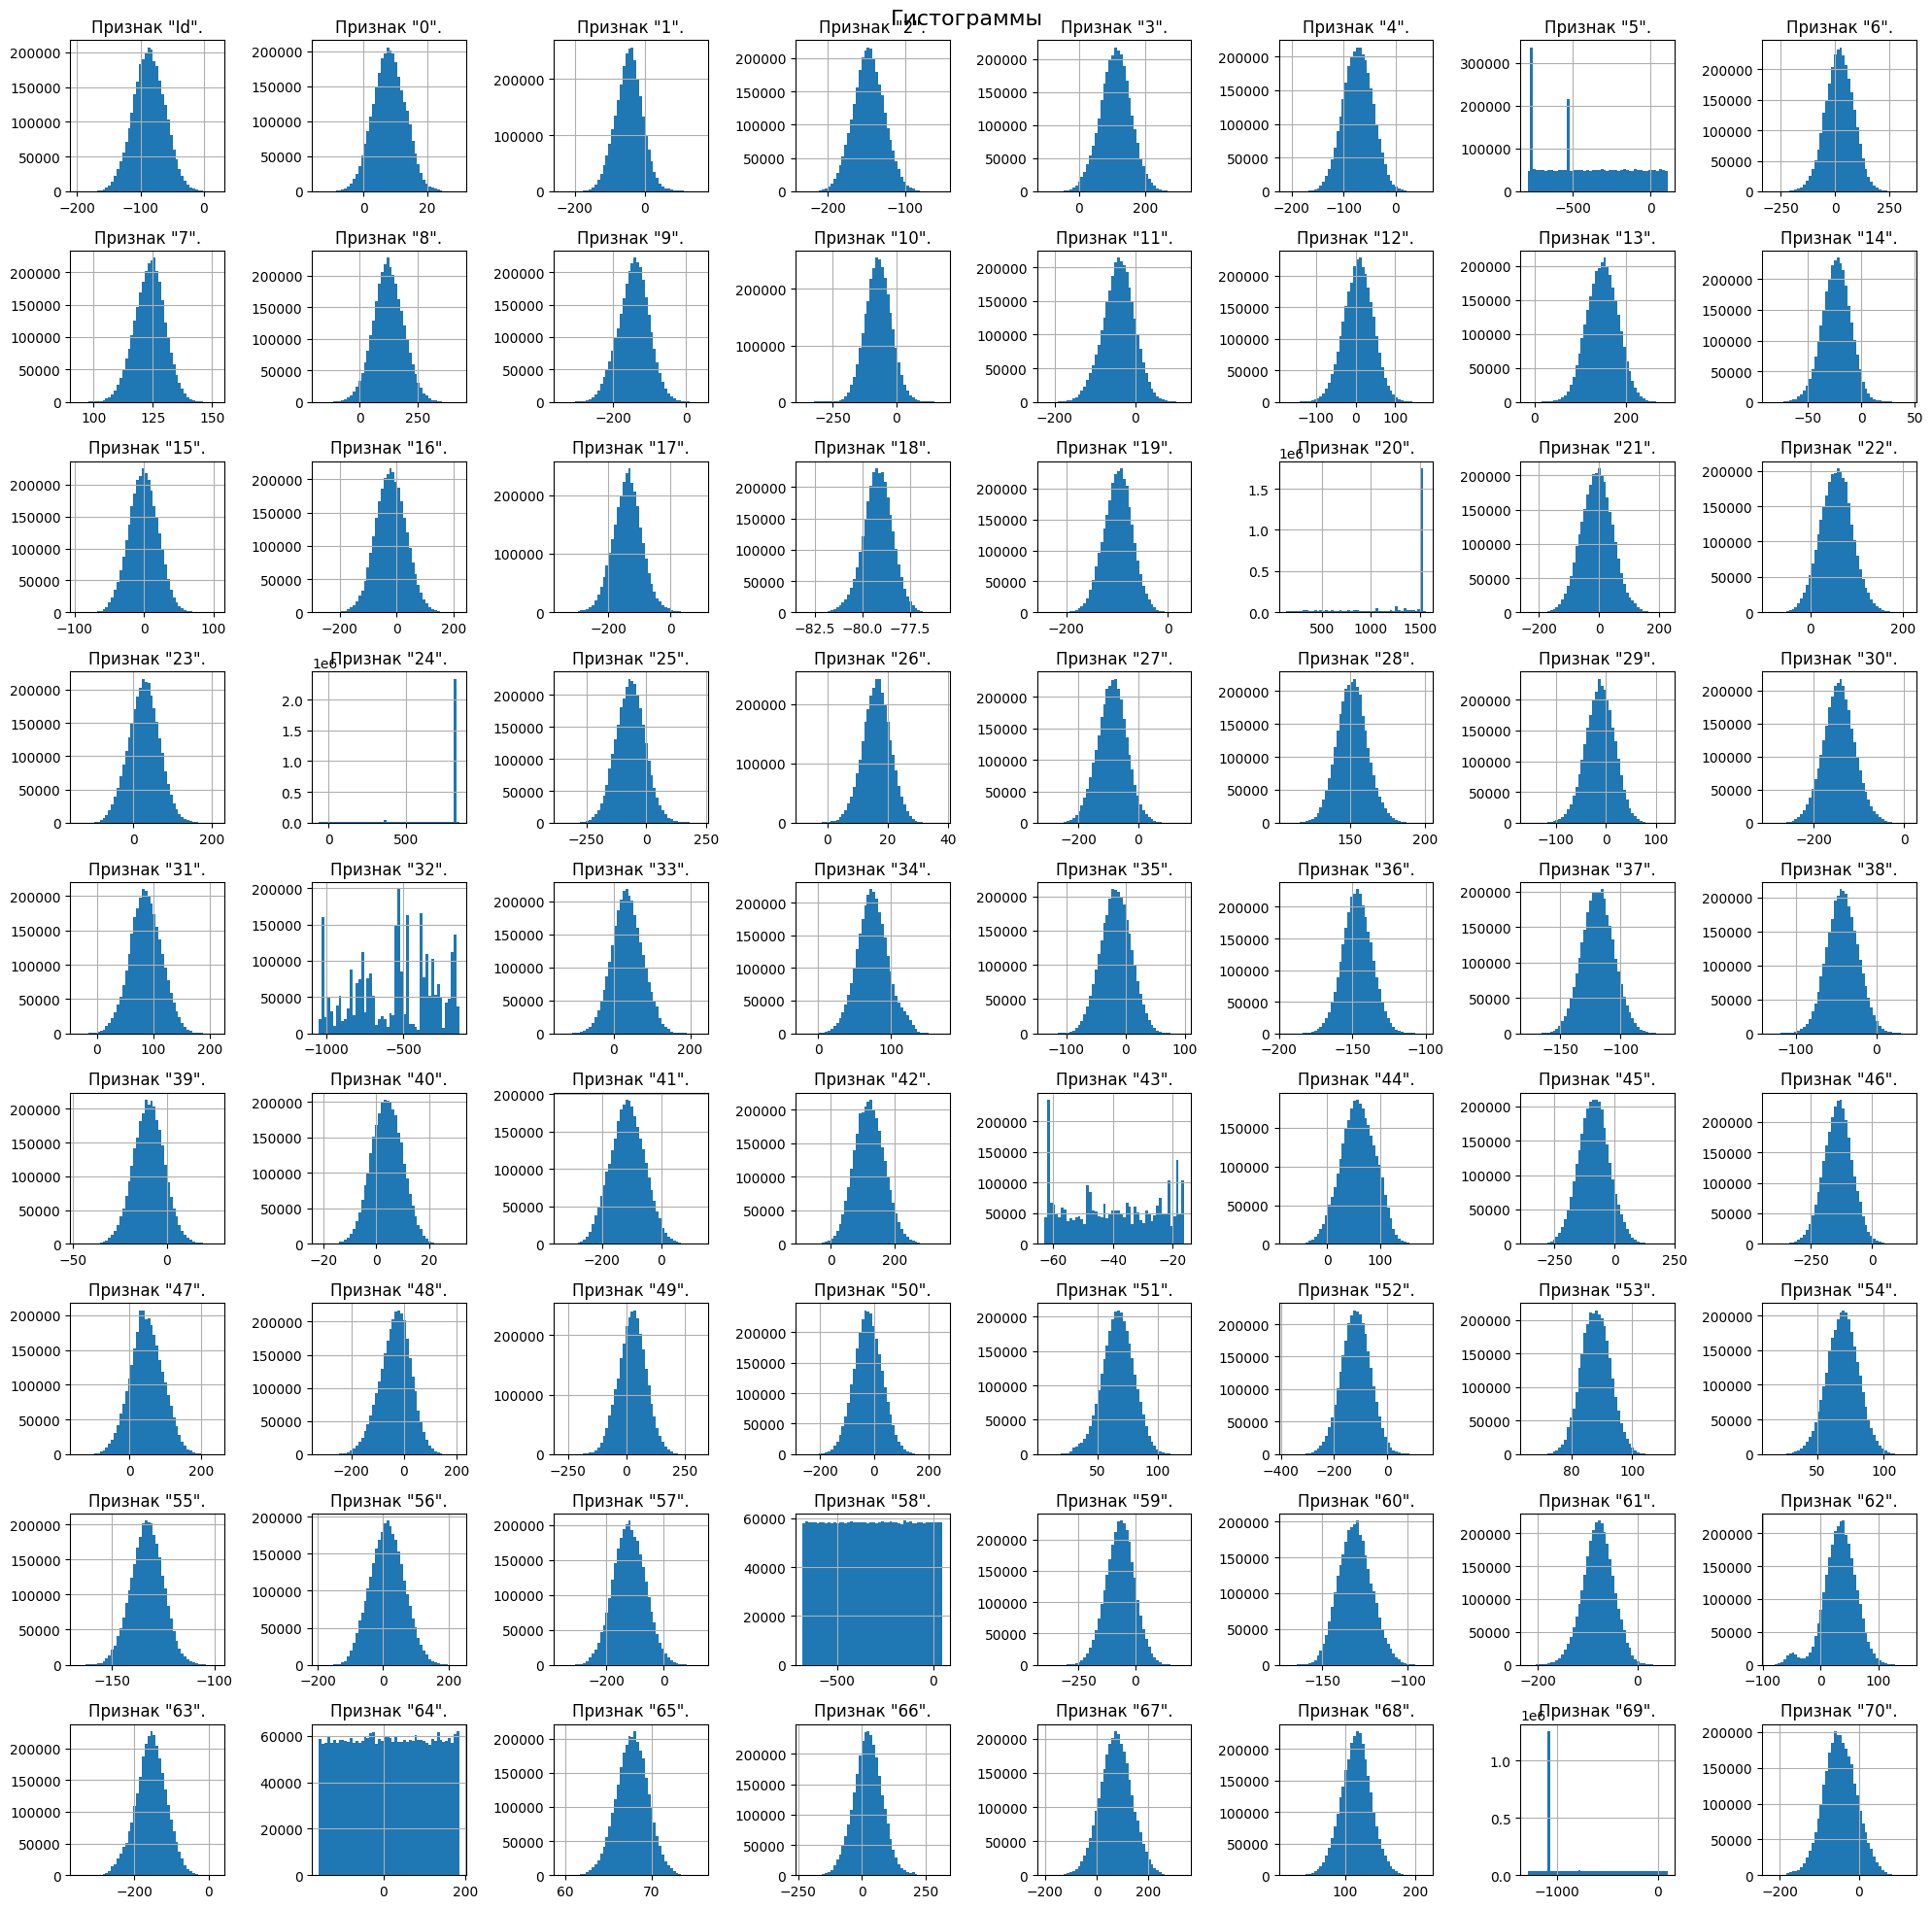

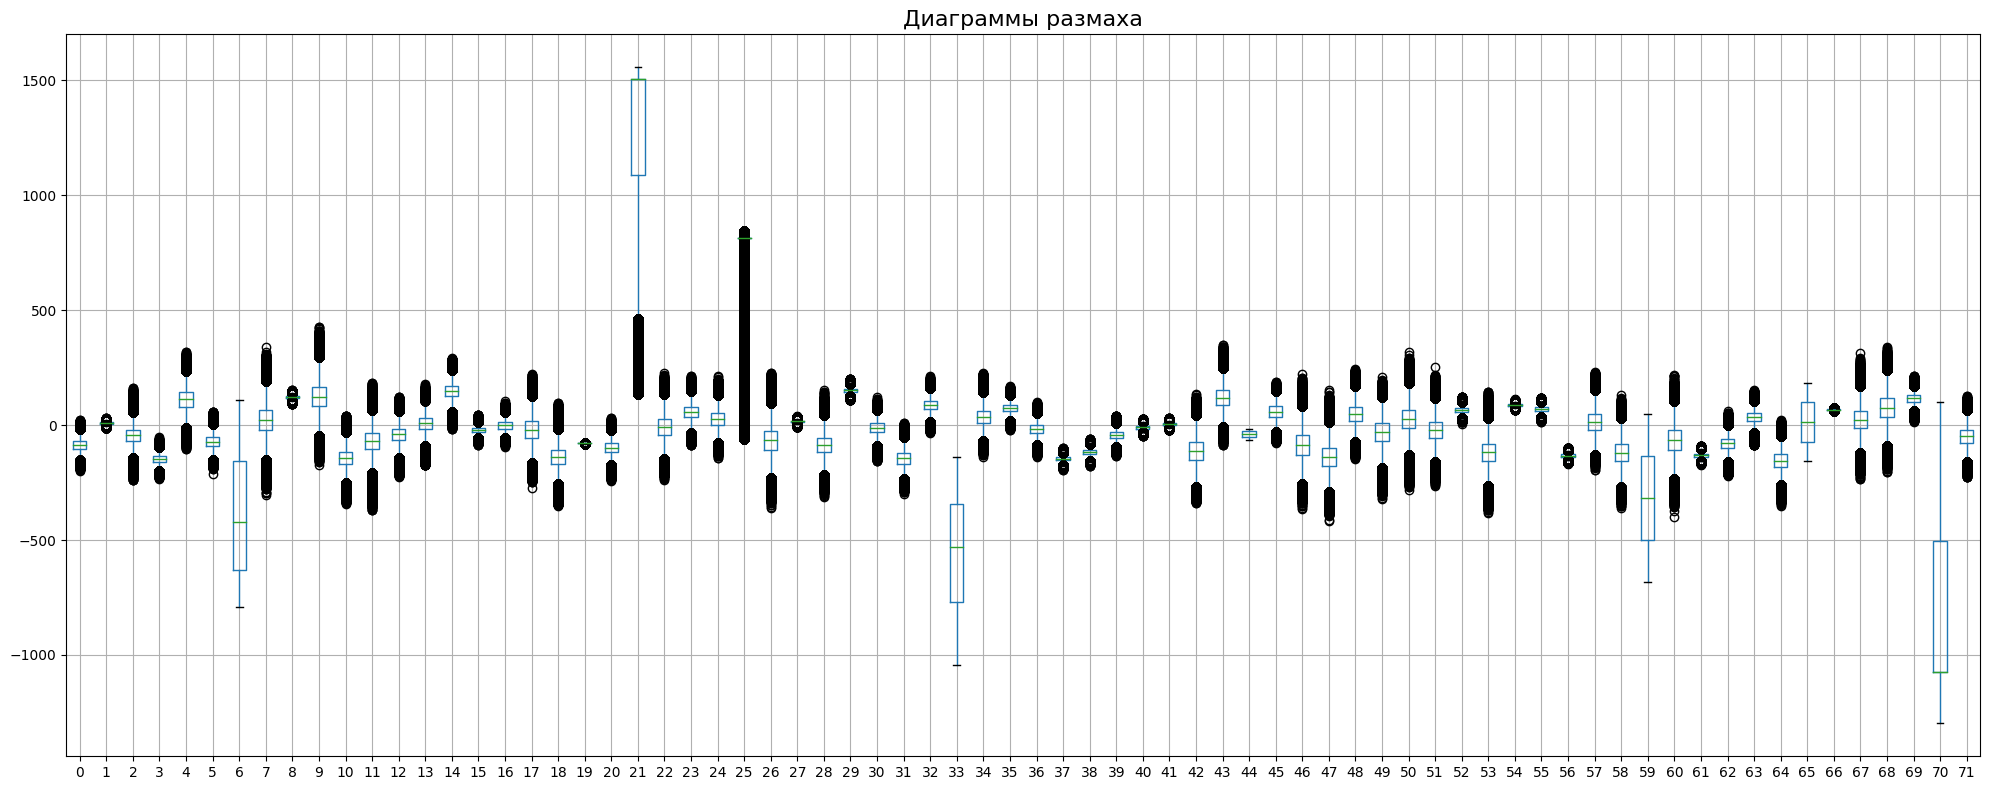

In [11]:
# построим графики base
get_hist_boxplot(data_base)

__Вывод:__  Данные состоят из 71 признаков и 2918139 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс значений. Имеются выбросы. Необходима стардартизация. Много памяти занимает датафрейм.

Предполагаю, что признаки 6 21 25 33 44 59 65 70 категориальные.

Признак 33, имеет 1568 уникальных значений. Это явно категориальный признак. Сложно предположить, что за категория, это явно не цвет и не размер. Возможно это город изготовления товара. Необходим подробный анализ признаков. 

###  Тренировочная выборка

In [12]:
# изучим данные train
info(data_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
95626,95626-query,-120.965866,3.473743,-85.225570,-152.749740,81.58440,-86.787520,-759.626065,26.220420,114.654700,161.25220,-158.761440,-82.493980,-74.949360,17.374702,111.693430,-29.766699,7.130483,29.839450,-39.270540,-78.608190,-93.754900,1165.781471,-32.039894,36.480103,3.886402,786.535135,4.458412,21.044477,-90.067260,162.84947,0.758945,-125.907940,56.707577,-892.701562,59.831745,46.102623,-0.598001,-149.27377,-118.806660,-27.975784,-26.445307,-11.438894,-108.667404,108.635864,-17.971408,22.865202,-170.210510,-228.366410,67.544670,-34.022580,98.970474,51.711190,66.233120,-53.461490,82.882545,68.138860,-143.77615,-7.539592,-193.396330,-589.594896,-133.164000,-132.62392,-89.870476,24.835270,-157.79047,115.357124,67.344505,-27.878017,183.412200,95.382230,-662.221943,-27.587750,234706-base
11950,11950-query,-112.022980,17.000454,-11.913731,-118.647095,131.32607,-90.302055,-25.899406,-14.077379,127.044580,194.27170,-106.011765,-42.260777,-40.925200,44.110886,142.189350,-21.572975,-49.849840,-119.727450,-56.770615,-77.617836,-54.046936,1507.231274,-25.502214,114.722530,69.041810,813.770071,-214.006600,21.923302,48.459824,142.32832,42.489754,-92.522385,97.905556,-481.586956,35.477882,64.855660,-2.548673,-145.42226,-122.186730,-51.091457,-25.999088,12.954747,11.933708,38.586440,-16.571622,89.483604,-64.186005,-133.483110,-13.319637,-12.833288,-56.868298,-73.001440,75.808480,-41.915054,87.863800,62.391380,-137.98235,14.168917,-93.863660,-579.767243,-105.425125,-134.70240,-40.034874,17.103855,-218.26700,-19.351641,66.247230,-88.553650,56.892586,139.317540,-152.182785,32.433560,1426700-base
41665,41665-query,-57.161613,-3.173597,-54.569435,-196.075910,166.77124,-66.190956,-472.397223,-38.523430,125.940850,214.63040,-179.286200,-38.853985,-68.439990,-22.862612,139.327960,-18.636936,3.991614,-30.979430,-119.359290,-78.566550,-108.668380,1507.231274,-33.306046,54.034237,55.234905,813.770071,-77.948590,27.871109,-45.732470,146.48058,-36.260498,-110.481540,101.364530,-481.586956,32.781387,98.599990,-29.738434,-159.29497,-141.421170,-46.795740,-14.001765,16.213768,-131.745120,122.166980,-43.988321,72.107790,-169.840770,-114.765640,-55.306545,-93.157240,55.030870,-48.274170,61.794437,23.574219,78.176320,80.383690,-128.84843,-26.048584,-85.946724,-511.136954,-13.524467,-134.18112,-39.280006,-24.719444,-171.83195,91.890886,67.436720,1.110424,-17.961746,95.233580,-707.157375,-60.169130,4725053-base
95708,95708-query,-72.749640,11.183364,18.131080,-151.809660,89.26602,-52.059490,-505.870332,-94.305550,120.524560,200.13956,-223.316770,-153.270610,-36.469776,39.848442,139.696430,-33.797005,-28.355583,70.951096,-94.451035,-80.018980,-83.181210,299.237514,28.977684,78.843285,57.234962,558.118882,-98.328470,15.775176,-70.737260,144.53003,-32.700893,-151.068300,93.744430,-482.951005,93.980430,53.724716,-82.866875,-147.40858,-129.830610,-61.662506,-20.540071,-1.950316,-142.022640,177.983690,-34.737709,29.403204,-12.958580,-189.029700,88.974560,-52.928738,-40.632830,-22.622711,78.271370,-107.740790,91.521850,87.528120,-133.51024,-52.063362,-246.611950,-198.743505,-5.386063,-114.92245,-94.405754,34.905580,-154.39497,-155.882296,68.665855,24.483774,124.949630,111.633270,-877.115737,-119.308716,187577-base
56407,56407-query,-85.623980,3.831602,-89.023160,-107.019325,111.04359,-40.264996,-759.626065,18.344145,117.884390,217.06366,-150.908110,-38.590510,-63.529907,-23.775137,109.318440,-17.126778,-18.992521,22.775723,-205.966610,-78.173240,-115.720230,1507.231274,-58.864567,87.281600,-3.288176,813.770071,-39.522984,13.981361,-122.829490,152.14833,-37.504528,-166.523860,97.059456,-499.053001,-26.593029,54.103340,-45.776352,-153.58524,-111.796860,-44.135980,-10.123932,7.245727,-3.171631,157.684390,-61.563913,103.085930,-107.956024,-182.133850,8

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.328679,25.803845,-186.280270,-103.309147,-85.273695,-67.330810,14.585236
1,100000.0,7.664345,4.955651,-11.560507,4.313784,7.652854,10.981191,28.917845
2,100000.0,-43.667046,39.111064,-224.896060,-69.494487,-42.830246,-17.713690,128.108460
3,100000.0,-146.118630,20.434841,-223.307220,-160.028520,-146.067445,-132.277745,-60.751625
4,100000.0,111.770592,47.700958,-93.272020,79.474322,112.260100,143.760830,301.363600
5,100000.0,-73.178792,28.718853,-184.962450,-92.834080,-73.364420,-53.699612,51.849710
6,100000.0,-440.615118,279.017550,-791.469482,-738.536868,-511.837758,-201.116578,109.625188
7,100000.0,21.231588,65.985214,-278.582820,-22.131764,22.278989,65.899595,288.171840
8,100000.0,123.067891,6.492081,94.831150,118.674642,123.087540,127.541802,149.356200
9,100000.0,126.120201,64.912752,-142.156950,82.545028,125.963340,169.701005,392.827150


Id        0
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        0
35        0
36        0
37        0
38        0
39        0
40        0
41        0
42        0
43        0
44        0
45        0
46        0
47        0
48        0
49        0
50        0
51        0
52        0
53        0
54        0
55        0
56        0
57        0
58        0
59        0
60        0
61        0
62        0
63        0
64        0
65        0
66        0
67        0
68        0
69        0
70        0
71        0
Target    0
dtype: int64
Количество дубликатов:  0
Количество признаков:  74 Количество значений:  100000


In [13]:
# количество уникальных значений таргета
data_train['Target'].nunique(dropna=True)

91794

__Вывод:__ Товары из base соответствуют нескольким значениям

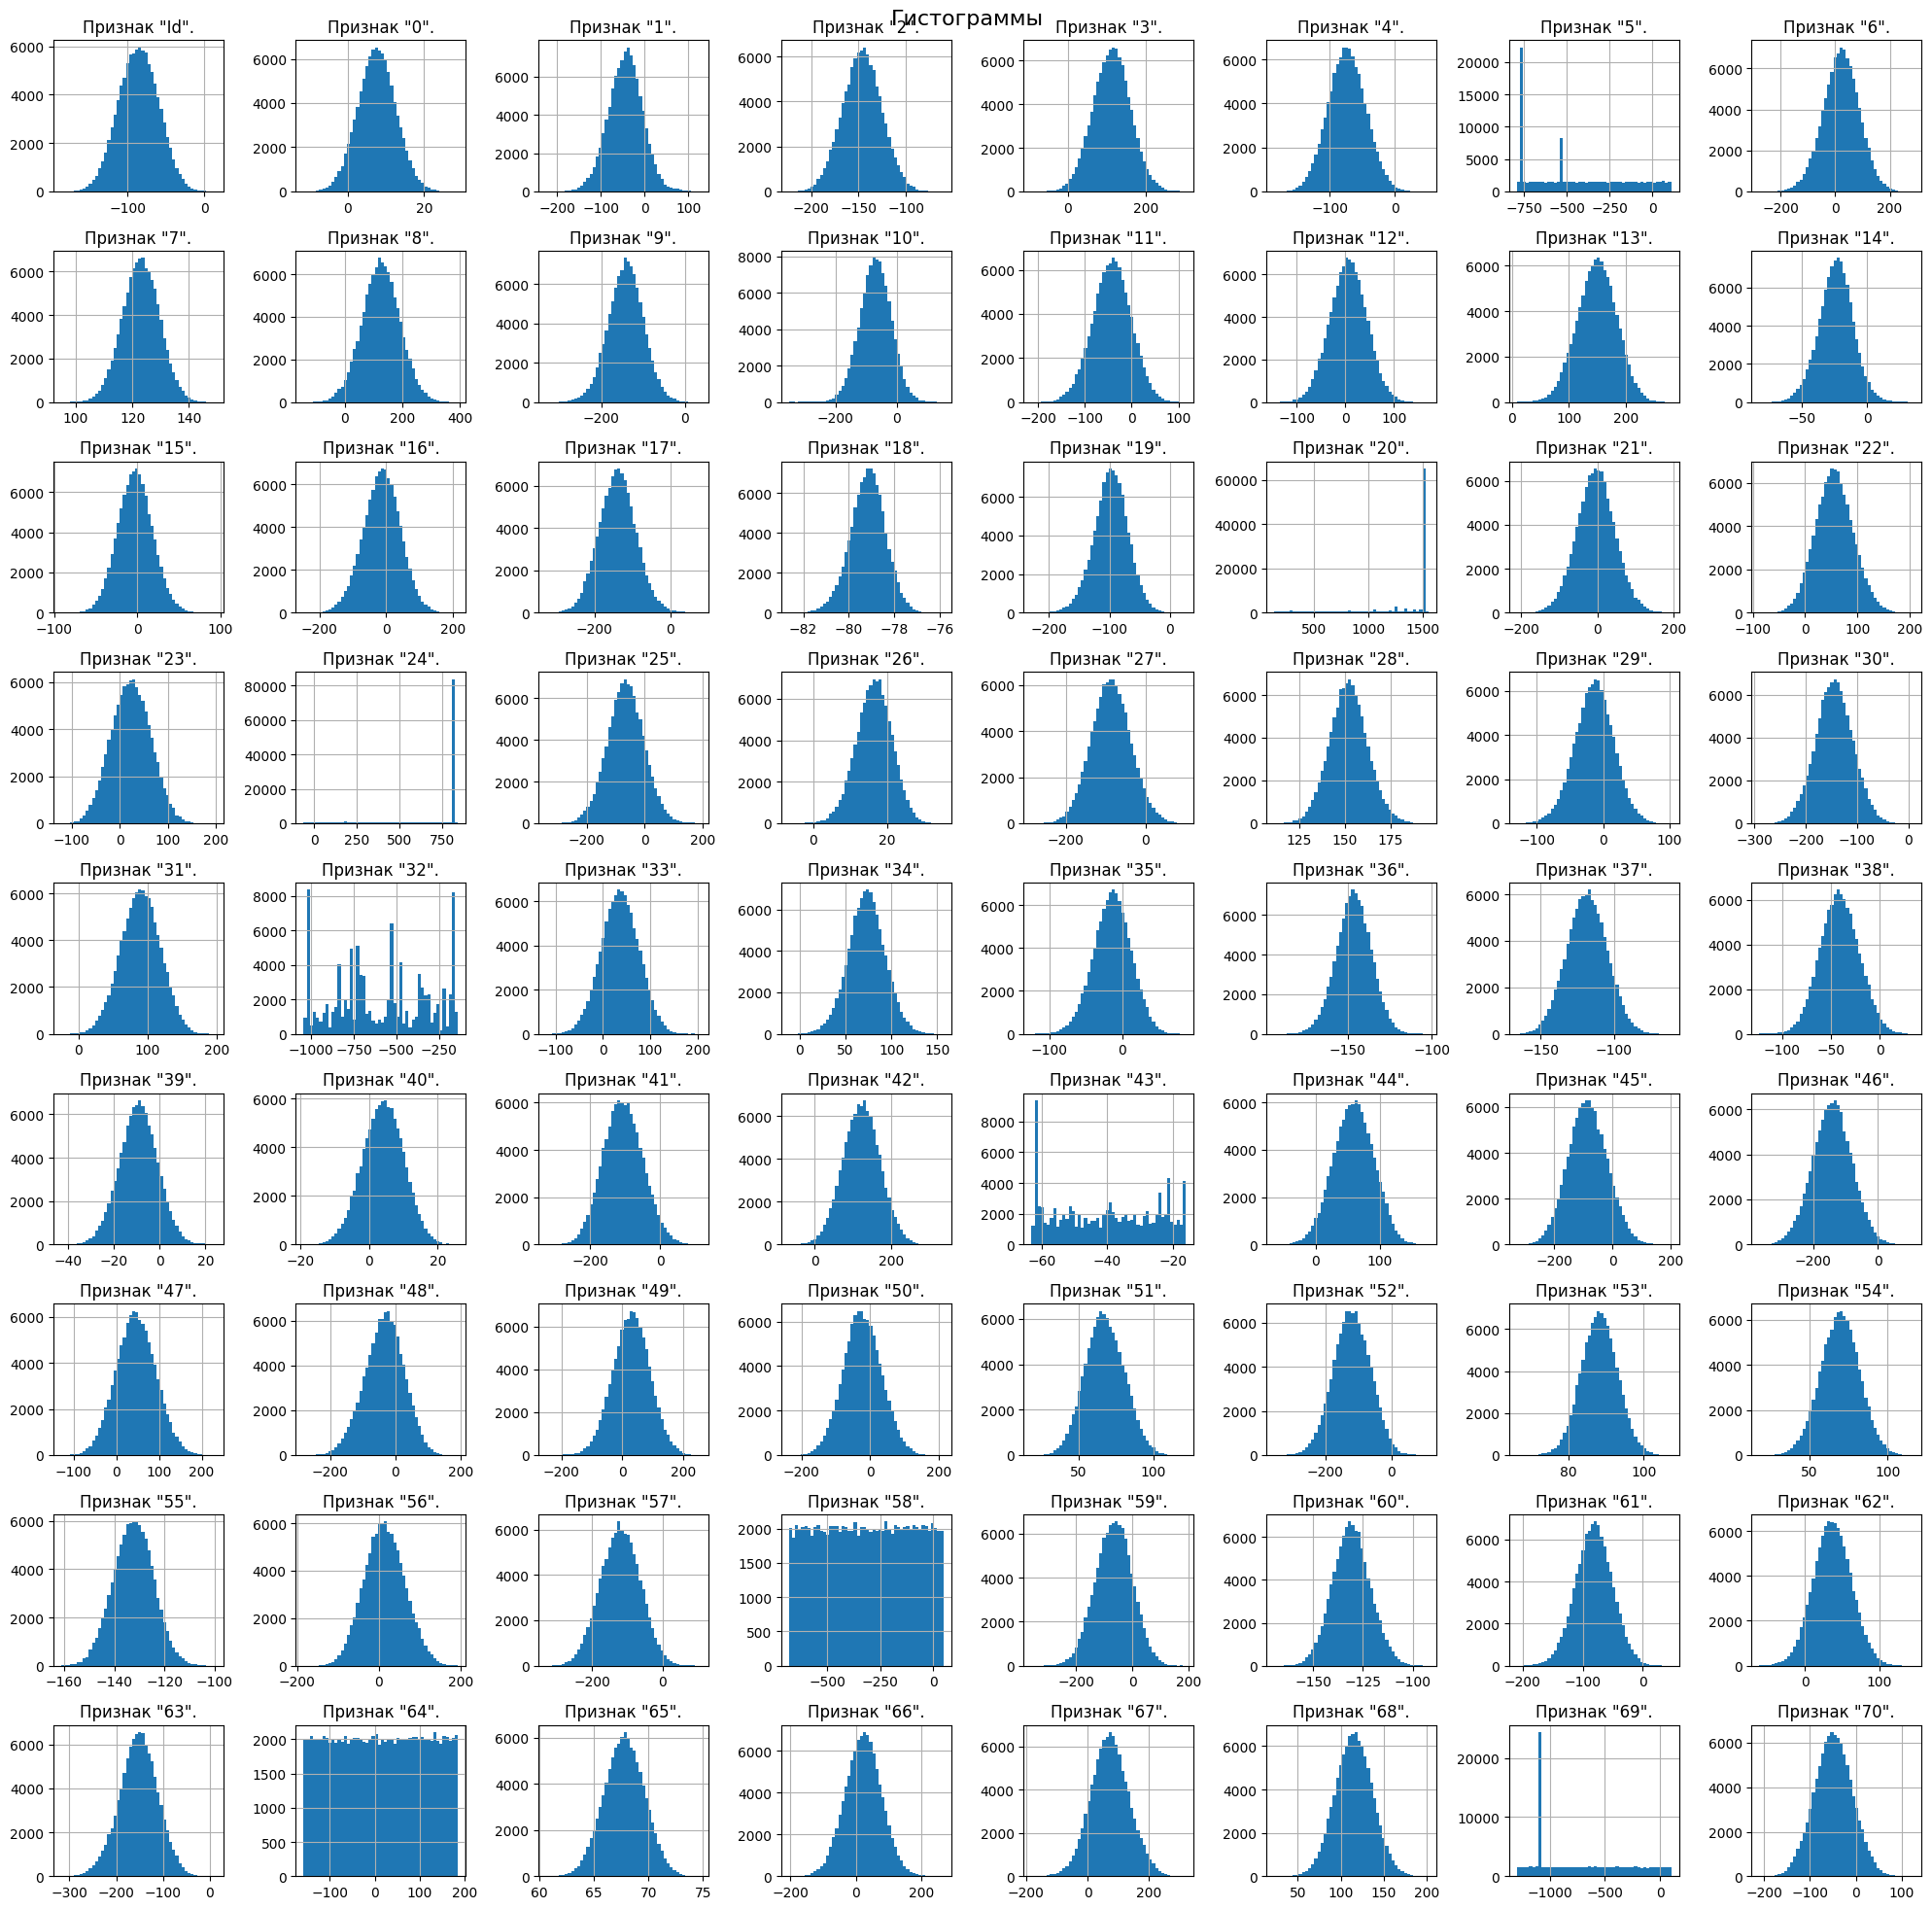

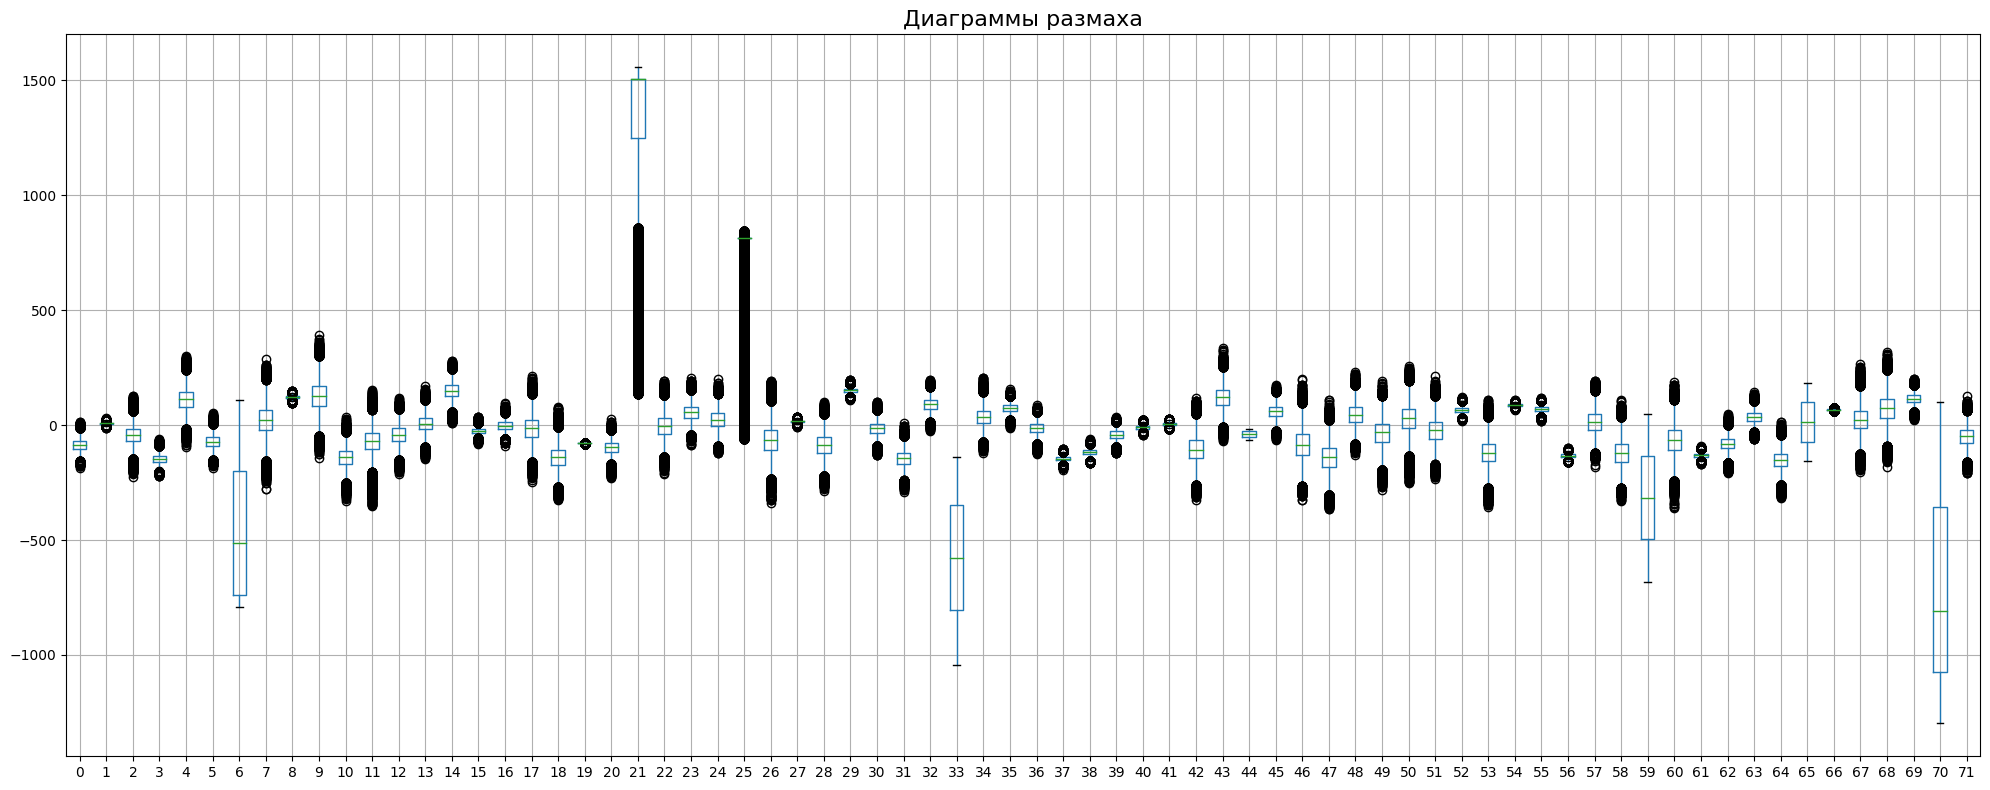

In [14]:
# построим графики train
get_hist_boxplot(data_train)

In [15]:
# количество уникальных значений в признаках
for col in data_train.columns:
    print(f'Количество уникальных значений {col}', {data_train[col].value_counts().count()})

Количество уникальных значений Id {100000}
Количество уникальных значений 0 {95977}
Количество уникальных значений 1 {96116}
Количество уникальных значений 2 {96174}
Количество уникальных значений 3 {95373}
Количество уникальных значений 4 {96049}
Количество уникальных значений 5 {95995}
Количество уникальных значений 6 {69462}
Количество уникальных значений 7 {96215}
Количество уникальных значений 8 {94591}
Количество уникальных значений 9 {96106}
Количество уникальных значений 10 {95911}
Количество уникальных значений 11 {96138}
Количество уникальных значений 12 {96168}
Количество уникальных значений 13 {96204}
Количество уникальных значений 14 {95791}
Количество уникальных значений 15 {96077}
Количество уникальных значений 16 {96249}
Количество уникальных значений 17 {96190}
Количество уникальных значений 18 {95967}
Количество уникальных значений 19 {84396}
Количество уникальных значений 20 {95949}
Количество уникальных значений 21 {20650}
Количество уникальных значений 22 {96199}
К

In [16]:
# выделим отдельно значение и его количество в признаке 33
unique, counts = np.unique(data_train['33'], return_counts= True)

# соберем датафрейм состоящий из уникального значения и его количества, отсортируем
cat_col_33 = pd.DataFrame(data={'unique': unique, 'counts': counts})
cat_col_33.sort_values(by='counts', ascending=False)

,unique,counts
1539,-156.249890,7715
49,-1018.469545,6858
927,-529.295053,6106
491,-771.296708,4420
560,-735.671365,3763
...,...,...
1046,-462.905493,1
141,-970.832209,1
1047,-460.697946,1
715,-654.553309,1


__Вывод:__  Имеем данные состоящие из 71 признаков и 100000 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс зрначений. Имеются выбросы. Необходима стардартизация. Много памяти занимает датафрейм.

Товары из base соответствуют нескольким значениям

Предполагаю, что признаки 6 21 25 33 44 59 65 70 категориальные.

### Validation

In [17]:
# изучим данные valid
info(data_valid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
31572,131572-query,-79.960550,3.131652,-40.170270,-126.898390,66.130950,-65.675705,-635.225409,-67.438660,123.09750,83.962135,-155.178440,-57.110740,-62.141197,-83.978380,197.972150,-14.159381,-21.620800,-76.056150,-60.388847,-80.314750,-108.135185,1507.231274,-52.679880,-38.678837,111.486084,813.770071,-134.905940,17.513248,-109.132310,156.13333,-22.348816,-192.90025,92.386250,-481.586956,42.016580,73.816900,-21.911268,-135.73465,-111.962456,-64.967545,-0.671592,5.817892,-60.596493,140.50604,-38.971868,33.801790,-123.816574,-160.738460,189.145540,-17.781763,83.887695,-40.751380,72.683000,-22.012589,80.133760,58.418480,-139.41824,44.555460,-75.14249,-471.908241,-110.239730,-136.563800,-67.788025,54.613760,-124.76979,109.182768,68.652860,47.661938,83.808655,116.18242,-1074.464888,-65.569990
72395,172395-query,-85.432040,0.699691,-102.645140,-157.949100,140.898200,-36.323166,-424.354380,152.527910,126.99246,67.424270,-148.887400,-94.889930,-37.785183,-20.458317,197.822850,-41.870460,-16.233625,-73.424300,-148.701430,-79.031166,-96.595795,1507.231274,27.241364,71.598340,-6.976765,813.770071,14.228981,22.313423,-78.692955,139.17249,1.434262,-155.12216,105.345436,-349.545030,23.234120,73.385550,18.911106,-156.91615,-135.321610,-31.946749,-8.527560,9.312726,-9.728569,121.60889,-19.660863,88.748870,-71.675440,-157.762730,58.200733,-71.230420,-56.706050,51.203278,43.840496,-76.920720,96.464424,34.091293,-129.30043,9.692498,-128.03061,-668.104068,56.390114,-131.970980,-93.123940,30.025206,-98.05374,50.909125,69.305830,28.311325,72.568610,109.17164,49.072871,-85.359960
70520,170520-query,-107.601610,16.212614,4.588242,-160.458760,173.413790,-86.774506,-230.524130,78.930435,137.60614,182.166400,-122.015656,-105.005130,-21.949322,71.922270,233.042880,-27.448656,1.805775,-53.464730,-141.474400,-79.347800,-102.665780,660.073352,-12.139742,12.415993,73.075670,813.770071,-161.858470,14.701428,-171.480180,150.95923,-38.116608,-123.82687,45.207016,-683.197634,94.712090,79.945470,-4.603718,-139.31108,-92.757360,-54.388420,-4.347189,16.139439,-129.612470,220.11397,-48.578687,106.576416,5.437294,-195.601910,118.238174,-150.353000,-68.898315,-8.316952,73.823810,-121.699905,88.558610,87.280870,-125.61903,-49.897762,-69.10654,-218.015440,-53.552864,-133.675460,-80.245330,30.030252,-134.01343,125.430660,68.049280,-11.017172,67.189740,123.69769,-915.797268,-66.919460
86363,186363-query,-129.843630,6.112376,2.709885,-174.552930,116.859760,-43.381570,-530.124724,128.403120,119.63819,114.883130,-189.375610,-37.637383,-29.595070,-44.499360,99.571106,-31.698198,-3.757040,14.730413,-183.203410,-77.798550,-111.714360,1069.249675,-75.725494,57.889370,6.536371,813.770071,-83.517810,23.113276,-1.057823,160.17708,10.256923,-105.97279,60.620410,-579.590387,33.552590,64.882250,-11.540907,-141.75441,-131.311830,-53.860153,-11.478683,8.199965,-45.394688,135.70012,-24.941861,25.535147,-49.085567,-143.084140,35.088080,-31.843273,17.892290,-9.605697,88.987595,-134.048780,92.198960,97.893220,-150.34444,60.399784,-133.93947,-635.291018,-152.004140,-131.739900,-63.151817,23.972563,-169.59543,-137.376694,68.265076,-113.106400,3.121685,92.19264,-589.140914,-44.763634
79781,179781-query,-99.741540,8.220176,-25.351992,-170.313260,146.278490,-89.729904,-45.128773,-34.037094,120.17457,171.844620,-125.348526,-62.363003,-4.861080,6.143410,111.297450,-20.134274,-4.880510,49.111294,-124.837230,-78.759254,-81.690390,367.423437,-29.292934,95.690460,-34.523647,813.770071,82.325226,11.774631,-53.239513,177.38086,17.364544,-181.62585,89.672010,-932.704206,89.805450,73.362890,-25.120655,-140.84808,-110.583540,-50.029064,-7.497979,4.698739,-195.020610,151.20364,-34.901610,58.074802,13.359497,-192.694630,-63.442340,-36.561940,70.720980,-13.394401,60.663685,-103.196290,90.647980,91.624

,count,mean,std,min,25%,50%,75%,max
0,100000.0,-85.302233,25.777321,-190.353330,-103.231790,-85.296745,-67.422104,14.427986
1,100000.0,7.669724,4.956990,-11.109877,4.292425,7.657888,10.993900,27.409784
2,100000.0,-43.842474,39.138775,-217.538420,-69.680916,-43.230835,-17.765821,134.859800
3,100000.0,-146.119797,20.495541,-220.050890,-160.210287,-146.080365,-132.119278,-57.381890
4,100000.0,111.635071,47.751576,-81.198990,79.101920,111.959330,143.903735,302.065370
5,100000.0,-73.273042,28.515740,-176.705030,-92.789803,-73.579283,-53.861139,50.255325
6,100000.0,-441.396759,279.242585,-791.460243,-740.620025,-513.922978,-202.572440,109.632035
7,100000.0,21.594242,66.478048,-265.608430,-21.804730,22.138012,66.097697,279.468900
8,100000.0,123.077725,6.504931,96.218350,118.657689,123.062568,127.538967,151.822560
9,100000.0,126.001062,64.981697,-135.667300,82.311205,126.083595,169.680500,392.827150


Id    0
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    0
65    0
66    0
67    0
68    0
69    0
70    0
71    0
dtype: int64
Количество дубликатов:  0
Количество признаков:  73 Количество значений:  100000


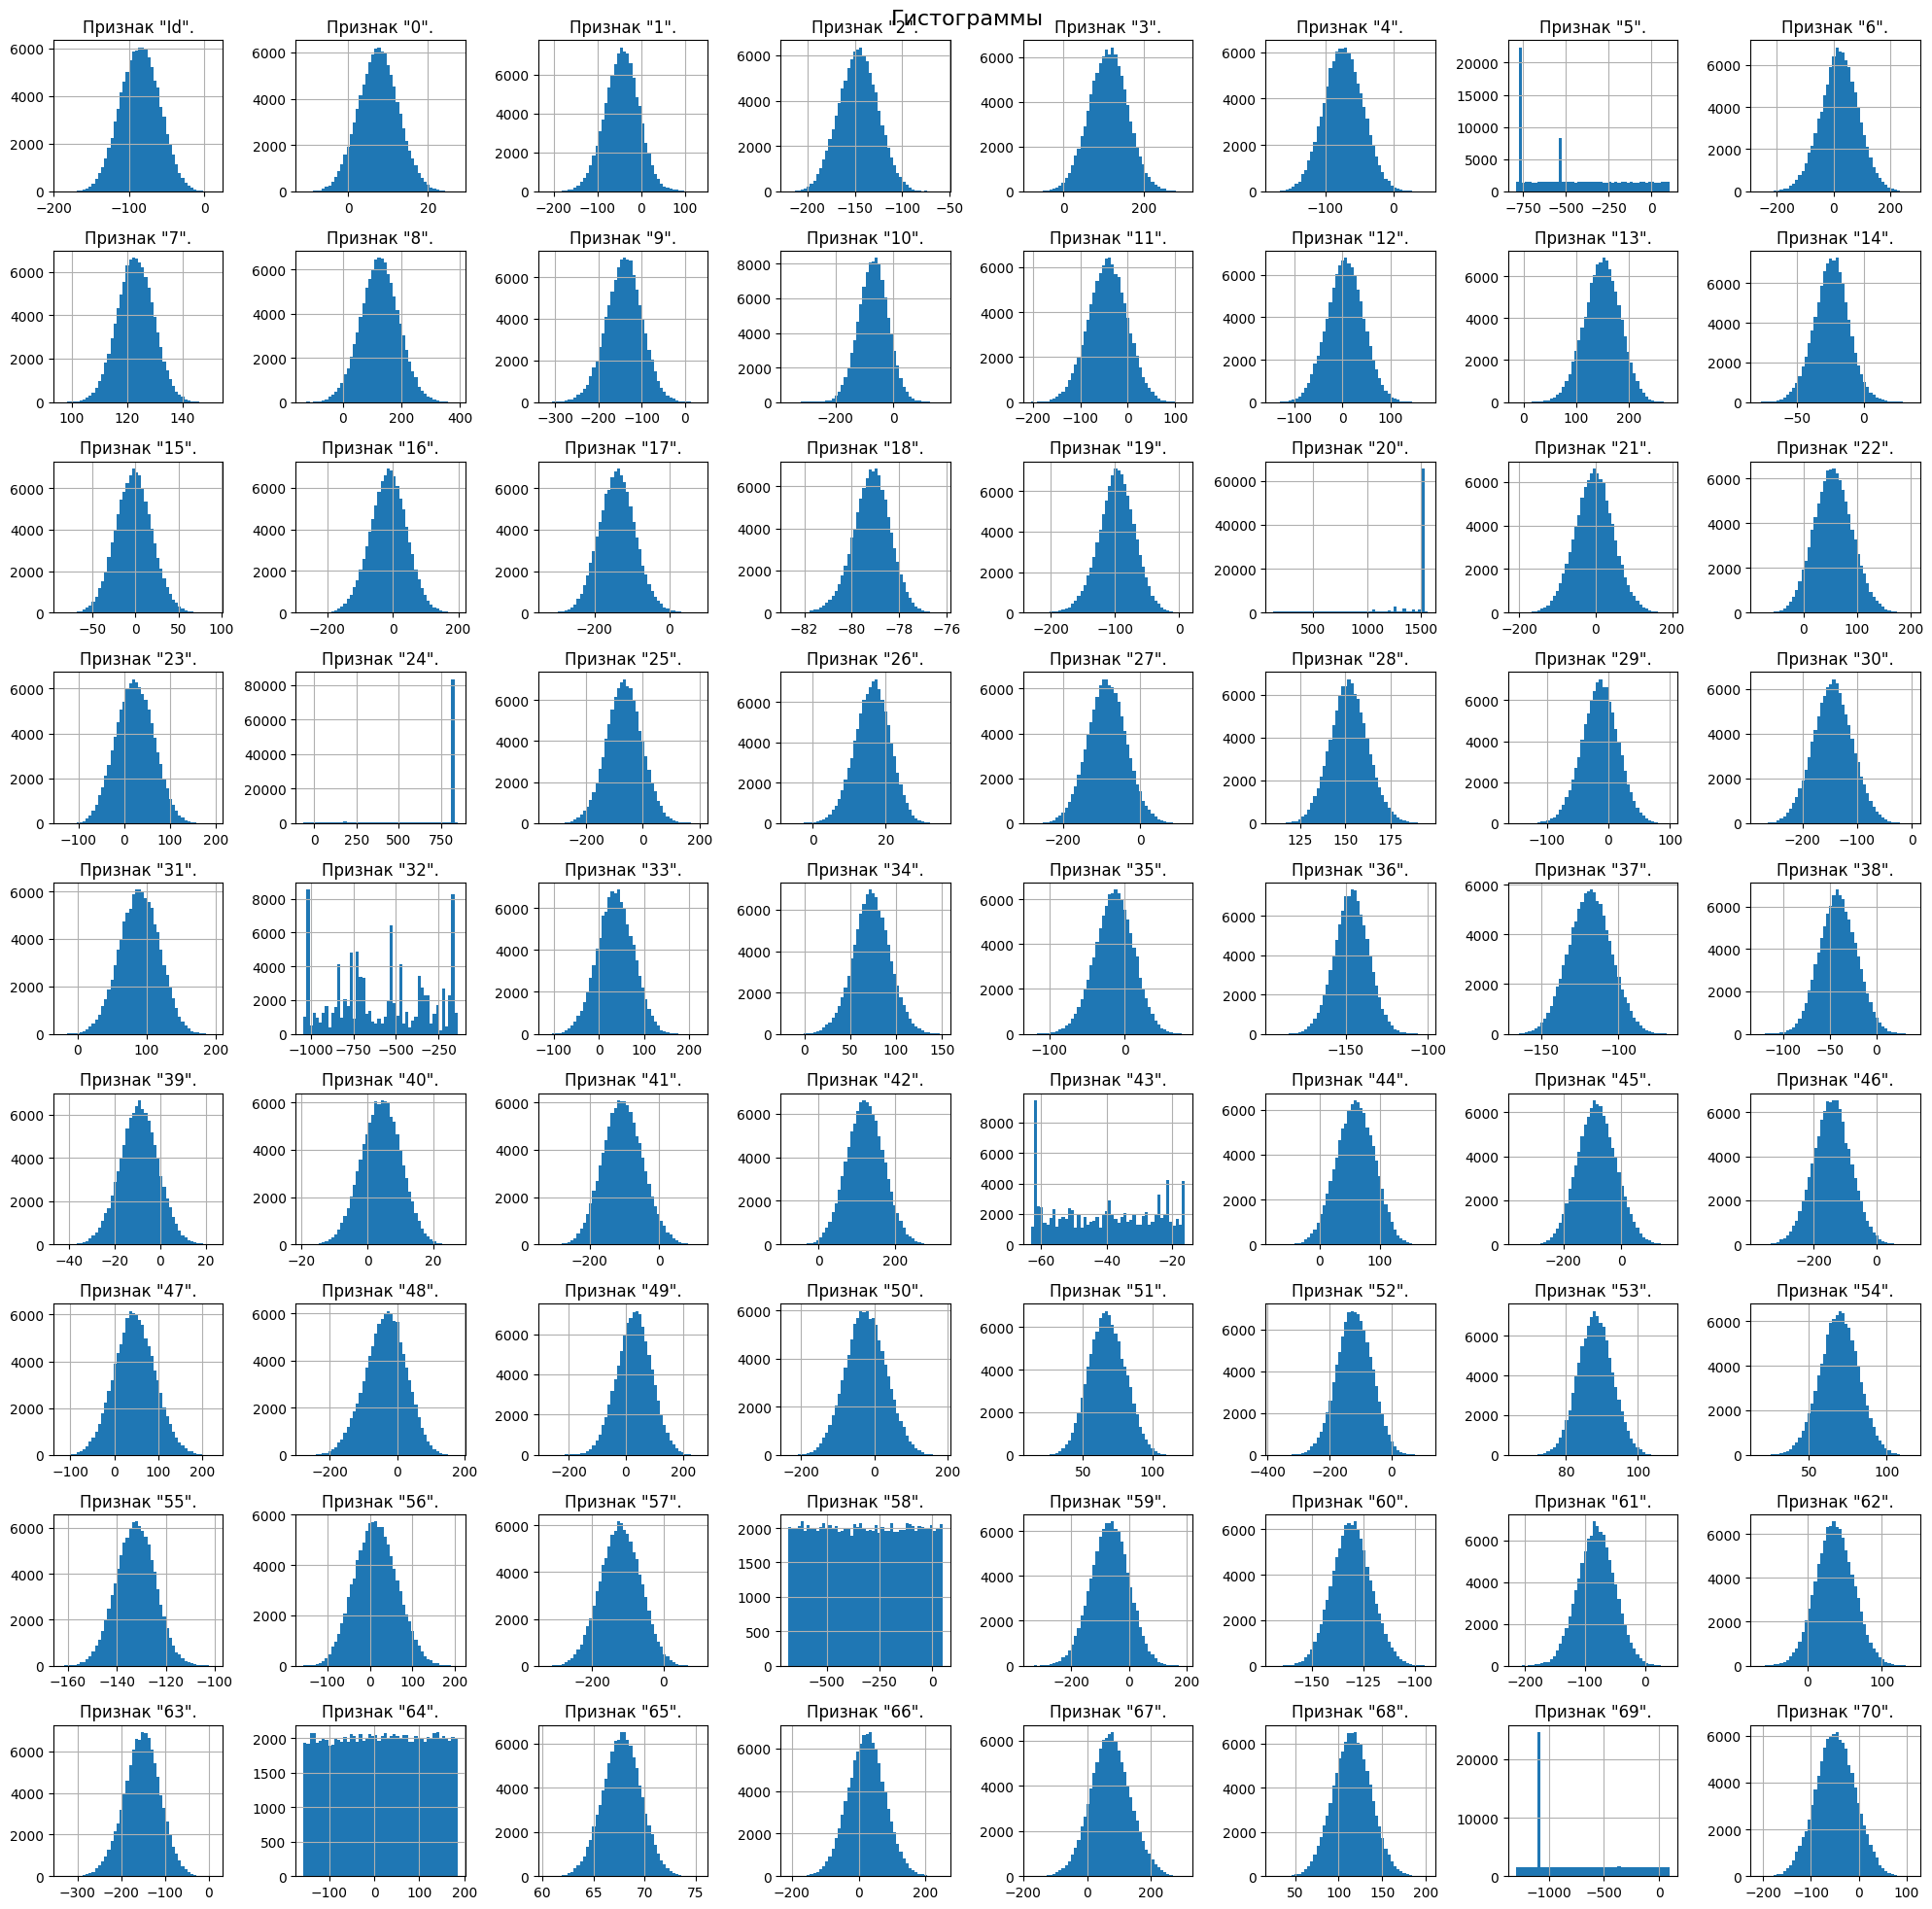

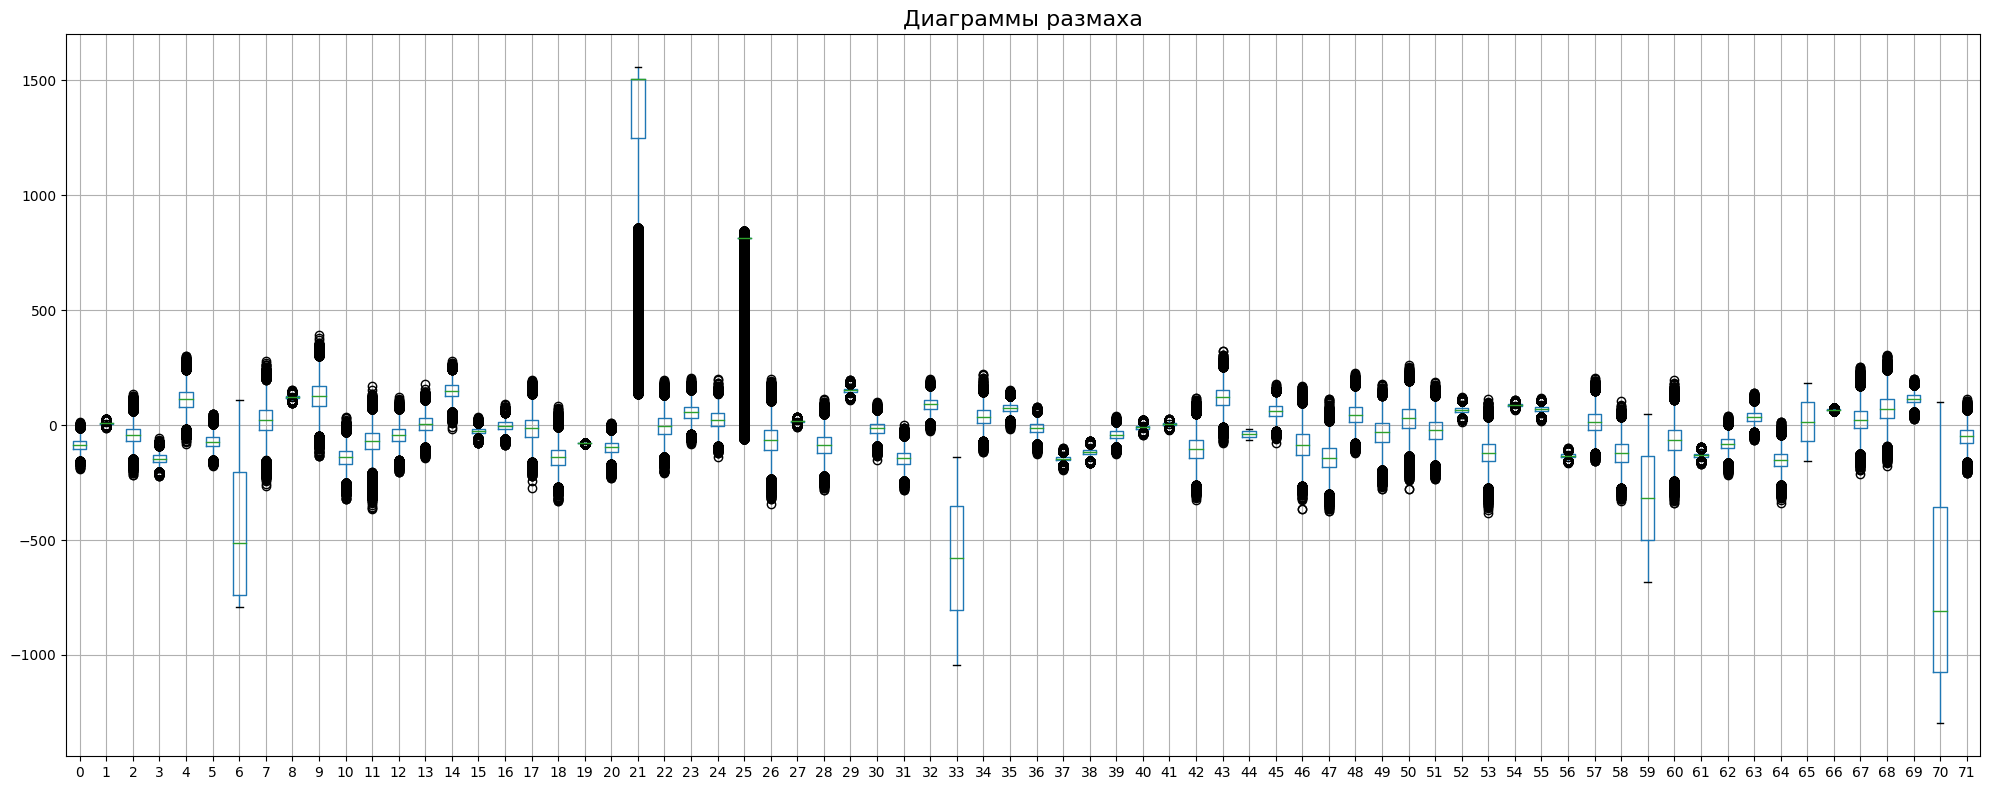

In [18]:
# построим графики valid
get_hist_boxplot(data_valid)

__Вывод:__  Имеем данные состоящие из 71 признаков и 1000000 записей. Пропуска и дубликаты отсутствуют. Данный очень разные. Встречаются как отрицальные, так и положительные, большой разброс зрначений. Необходима стардартизация. Много памяти занимает датафрейм.

Предполагаю, что признаки 6 21 25 33 44 59 65 70 категориальные.

### Answer

In [19]:
info(data_valid_answer)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


None

,Id,Expected
4425,104425-query,3802737-base
7736,107736-query,35219-base
59002,159002-query,1087214-base
27194,127194-query,2419747-base
85214,185214-query,104329-base
32268,132268-query,444500-base
78236,178236-query,94075-base
9735,109735-query,962873-base
89908,189908-query,274158-base
3378,103378-query,1177916-base


,count,unique,top,freq
Id,100000,100000,105573-query,1
Expected,100000,91502,210304-base,7


Id          0
Expected    0
dtype: int64
Количество дубликатов:  0
Количество признаков:  2 Количество значений:  100000


__Вывод:__ Имеем даннные, состоящие из 2-х признаков и 100000 значений.
    
Товары из base соответствуют нескольким значениям

## EDA

In [20]:
# сделаем копию датасетов
temp_data_base = data_base.copy()
temp_data_train = data_base.copy()
temp_data_valid = data_base.copy()
temp_data_valid_answer = data_base.copy()

###  Запишем названия признаков в нижнем регистре

In [21]:
# приведем все к нижнему регистру
# запишем как функцию
def make_low_cols(data):
    data.columns = map(str.lower, data.columns)
    return data

In [22]:
# Запишем названия признаков в нижнем регистре
make_low_cols(data_base)
make_low_cols(data_train)
make_low_cols(data_valid)
make_low_cols(data_valid_answer)

,id,expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base
...,...,...
99995,199995-query,967418-base
99996,199996-query,1344948-base
99997,199997-query,1690782-base
99998,199998-query,341779-base


### Поменяем тип данных

In [23]:
# функция для изменения типа данных 
def col_type_trans(data):
    cols = data.select_dtypes(include='float').columns.tolist()
    for col in cols:
        data[col] = data[col].astype(np.float32) 
    return data

In [24]:
# поменяем тип данных да float32 для уменьшения памяти
col_type_trans(data_base).dtypes
col_type_trans(data_train).dtypes
col_type_trans(data_valid).dtypes

id     object
0     float32
1     float32
2     float32
3     float32
4     float32
5     float32
6     float32
7     float32
8     float32
9     float32
10    float32
11    float32
12    float32
13    float32
14    float32
15    float32
16    float32
17    float32
18    float32
19    float32
20    float32
21    float32
22    float32
23    float32
24    float32
25    float32
26    float32
27    float32
28    float32
29    float32
30    float32
31    float32
32    float32
33    float32
34    float32
35    float32
36    float32
37    float32
38    float32
39    float32
40    float32
41    float32
42    float32
43    float32
44    float32
45    float32
46    float32
47    float32
48    float32
49    float32
50    float32
51    float32
52    float32
53    float32
54    float32
55    float32
56    float32
57    float32
58    float32
59    float32
60    float32
61    float32
62    float32
63    float32
64    float32
65    float32
66    float32
67    float32
68    float32
69    float32
70    

__Вывод:__ Поменяла тип на float32, так как только с ним раьотаект библиотека Faiss. И меньше памяти занимают данные.

### Уберем категориальные данные

In [25]:
#дропнула 21, 25, 33 44, 59, 65
data_base = data_base.drop(data_base.columns[[22, 26, 34, 45, 60, 66]], axis=1)

data_train = data_train.drop(data_train.columns[[22, 26, 34, 45, 60, 66]], axis=1)

data_valid = data_valid.drop(data_valid.columns[[22, 26, 34, 45, 60, 66]], axis=1)

In [26]:
# зафиксируем метрику, при удалении признака 6 и 70
features = ['21-65', '6', '70'] # признаки которые дропнула
accuracy_f = ['71.95', '71.48', '71.61'] # метрика при удалении признаков

# собирем все в таблицу
df_drop_features = pd.DataFrame({'features': features, 'accuracy@5': accuracy_f})

# посмотрим таблицу
display(df_drop_features)

,features,accuracy@5
0,21-65,71.95
1,6,71.48
2,70,71.61


__Вывод:__ В ходе эксперементов по удалению признаков, признаки 6 и 70 решено было оставить. Так как при удалении, метрика падала.

Сдала вывод, чем меньше у категориальных признаков уникальных значений, тем хуже они влияют на метрику.

### Перезапишем id

In [27]:
# функция для замены индекса
def make_index(data):
    data = data.set_index('id')
    return data

In [28]:
# заменим индексы
data_base = make_index(data_base)
data_train = make_index(data_train)
data_valid = make_index(data_valid)
data_valid_answer = make_index(data_valid_answer)

In [29]:
# посмотрим на результат удаления признаков
print(temp_data_base.shape, data_base.shape)
print(temp_data_train.shape, data_base.shape)
print(temp_data_valid.shape, data_base.shape)
print(temp_data_valid_answer.shape, data_base.shape)

(2918139, 73) (2918139, 66)
(2918139, 73) (2918139, 66)
(2918139, 73) (2918139, 66)
(2918139, 73) (2918139, 66)


### Масштабируем признаки

В ходе эксперемента RobustScaler показал себя лучше всего. С ним удалось добиться самой высокой метрики.

In [30]:
# зафиксируем результаты эксперемента
scaler = ['RobustScaler', 'StandartScaler'] # какие scaler использовала
accuracy_s  = ['71.95', '71.92'] # какие метрики получила

# соберем все в таблицу
df_scaler = pd.DataFrame({'scaler': scaler, 'accuracy@5': accuracy_s})

# посмотрим таблицу
display(df_scaler)

,scaler,accuracy@5
0,RobustScaler,71.95
1,StandartScaler,71.92


In [31]:
# Масштабимруем RobustScaler
scaler = RobustScaler()

In [32]:
# Обучаем на base и трансформируем
base_trans = scaler.fit_transform(data_base)

In [33]:
# делим трейн на фичи и таргет
train_features = data_train.drop('target', axis=1)
train_target = data_train['target'] 

In [34]:
# трансформируем трейн
train_trans = scaler.transform(train_features)

# трансформируем валид
valid_trans = scaler.transform(data_valid)

In [35]:
# создание словаря для нахождения индекса товара в базовом наборе данных
base_index = {k: v for k, v in enumerate(data_base.index.to_list())}

### Подберем класторы

In [36]:
# функция подбора кластеров
def get_clastering_coeff(df: pd.DataFrame(),\
                        n_clusters: list,
                        model = KMeans):
    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]
    print ('Коэффицент схожести Девиса_Боулдина:' 'Mеньше - лучше. Минимум - 0')
    
    for ni in tqdm(n_clusters):
        if model == MiniBatchKMeans: # подбираем на MiniBatchKMeans
            cluster_k = MiniBatchKMeans(n_clusters=ni, \
                                        init = 'k-means++', 
                                        n_init = 'auto', 
                                        batch_size=1536, # размер батчей
                                        random_state = RANDOM_STATE).fit(df)
   
        db_score = davies_bouldin_score(df, cluster_k.labels_) # считаем коэффицент Девиса_Боулдина 
        print(f'{ni} кластеров: {round(db_score, 3)}.\n-----')                   

In [37]:
# подбирем кластеры 
get_clastering_coeff(df=data_base, n_clusters=[10, 20, 50, 100, 200, 300, 400, 500, 1000], model = MiniBatchKMeans)

Коэффицент схожести Девиса_Боулдина:Mеньше - лучше. Минимум - 0


 11%|█████                                        | 1/9 [00:07<01:02,  7.77s/it]

10 кластеров: 2.753.
-----


 22%|██████████                                   | 2/9 [00:16<00:57,  8.14s/it]

20 кластеров: 3.888.
-----


 33%|███████████████                              | 3/9 [00:26<00:53,  8.94s/it]

50 кластеров: 3.68.
-----


 44%|████████████████████                         | 4/9 [00:38<00:50, 10.15s/it]

100 кластеров: 4.009.
-----


 56%|█████████████████████████                    | 5/9 [00:54<00:49, 12.41s/it]

200 кластеров: 3.495.
-----


 67%|██████████████████████████████               | 6/9 [01:15<00:46, 15.45s/it]

300 кластеров: 3.315.
-----


 78%|███████████████████████████████████          | 7/9 [01:47<00:41, 20.87s/it]

400 кластеров: 3.209.
-----


 89%|████████████████████████████████████████     | 8/9 [02:19<00:24, 24.39s/it]

500 кластеров: 3.096.
-----


100%|█████████████████████████████████████████████| 9/9 [03:16<00:00, 21.78s/it]

1000 кластеров: 2.887.
-----


__Вывод:__ Лучшую метрику даст нам разбиение на 10 кластеров.

## Faiss

### Train

В ходе обучения модели на тренировочной выборке, были рассмотрены модели с 3-мя разными индексами.

1) IndexHNSWFlat. Дает нам высокую скорость ~ 30 минут, но метрика accuracy@5 оказалась равной 59.34.

2) IndexFlatL2. Скорость работы данного алгоритма ~ 1 час. Получили метрику accuracy@5, равную 71.95

3) IndexHNSWFlat+IndexIVFFlat. Счетание двух индексов дал нам метрику accuracy@5, равную 71.8, но скрость работы выросла до  ~ 4 часов.

In [38]:
faiss_index = ['IndexHNSWFlat', 'IndexFlatL2', 'IndexHNSWFlat+IndexIVFFlat']
score = ['59.34', '71.95', '71.8']
time = ['30min 52s', '1h 7min 20s', '4h 3min 43s']
result = pd.DataFrame({'faiss index': faiss_index, 'accuracy@5': score, 'time': time})
display(result)

,faiss index,accuracy@5,time
0,IndexHNSWFlat,59.34,30min 52s
1,IndexFlatL2,71.95,1h 7min 20s
2,IndexHNSWFlat+IndexIVFFlat,71.8,4h 3min 43s


In [39]:
%%time
# размер пространиства
dimensions = base_trans.shape[1] 

# задает индекс
index = faiss.IndexFlatL2(dimensions)

# обучение индекс на base_trans
index.train(np.ascontiguousarray(base_trans))

# добавим векторы в индекс
index.add(np.ascontiguousarray(base_trans))

# задаем количество посещаемых кластеров
index.nprobe = NPROBE

# записываем индексы подобранных товаров и расстояния до них
train_dist, train_idx = index.search(np.ascontiguousarray(train_trans), K_NEIGHBORS)

CPU times: user 50min 23s, sys: 40.5 s, total: 51min 3s
Wall time: 31min 10s


In [40]:
# для 5 ближайших товаров расчитываем метрику accuracy@5 
acc = 0
for target, candidates in zip(train_target.values.tolist(), train_idx.tolist()):
    acc += int(target in [base_index[number] for number in candidates])

print('accurasy@5', round(acc / len(train_idx) * 100, 2))

accurasy@5 71.95


__Вывод:__ На тренировочной выборке удалось добиться метрику accurasy@5 71.95

### Valid

In [41]:
%%time
# Применим наш подход на валидационной выборке, записываем индексы подобранных товаров и расстояния до них
val_dist, val_idx = index.search(np.ascontiguousarray(valid_trans), K_NEIGHBORS)

CPU times: user 52min 11s, sys: 1min 2s, total: 53min 14s
Wall time: 25min 24s


In [42]:
# привильные ответы
data_valid_answer = data_valid_answer['expected']

In [43]:
# для 5 ближайших товаров расчитываем метрику accuracy@5
acc = 0
for target, candidates in zip(data_valid_answer.values.tolist(), val_idx.tolist()):
    acc += int(target in [base_index[number] for number in candidates])

print('accurasy@5', round(acc / len(val_idx) * 100, 2))

accurasy@5 71.8


__Вывод:__ На валидационной выборке удалось добиться метрики accurasy@5 71.8

# Общий вывод:

1) В ходе работы нам были предоставлены 4-и датасета.

base.csv - анонимизированный набор всех товаров. Каждый товар имеет уникальный id. Вектор признаков имеет размерностью 72 и количество значения 2918139.

train.csv - обучающий набор товаров. Каждый товар имеет уникальный id. Вектор признаков имеет размерность 73 и количество значений 100000.

validation.csv - набор товаров для которых надо найти наиболее близкие товары из base.csv. Вектор признаков имеет размерность 72 количество значений 100000.

validation_answer.csv - набор товаров, с разметкой похожих для товаров из validatation.csv. Каждый товар имеет уникальный id. Количество значений 100000.

2) Данный хорошо подготовлены, отсутствуют пропуска и дубликаты. Все признаки кроме 6 21 25 33 44 59 65 70 имеют стремятся к нормальное распределение. Встречаются как отрицальные, так и положительные, большой разброс зрначений.
Предположительно признаки 6 21 25 33 44 59 65 70 являются категориальнымми. 

Изучили признак 33, он имеет 1568 уникальных значений. Это явно категориальный признак. Сложно предположить, что за категория, это явно не цвет и не размер. Возможно это город изготовления товара.

3) Была проведена подготовка данных, а именно: 

 - убрали некоторые категориальные данные, которые плохо влияли на мерику. Чем меньше у категориальных признаков уникальных значений, тем хуже они влияют на метрику
 - изменили тип данныех
 - записали название признаков в нижнем регистре
 - перезаписали index
 - для масштабирования данных был применен RobustScaler, он показал себя лучше при анализе метрики
 - подобрали число кластеров для Faiss.

4) Для нахождения 5-ти вариантов наиболее похожих товаров из base для train выборки. Была применина библиотека Faiss. Для этого мы провели обучения с размыми индексами: 'IndexHNSWFlat', 'IndexFlatL2', 'IndexHNSWFlat+IndexIVFFlat'. Обучили индекс на base. На тренировочной выборке удалось добиться метрику accurasy@5 = 71.95 используя индекс IndexFlatL2, время работы алгоритма ~ 1 час. 

5) При использовании бибилиотеки Faiss для нахождения 5-ти вариантов нахождения наиболее похожих товаров из base для valid выборки мы применили метод IndexFlatL2 (евклидово расстояние). Так как он показал лучшую, метрику относильно скорось работы. На валидационной выборке удалось добиться метрики accurasy@5 = 71.8.